# Age masks for daily climatology

Creating a water mass mask, for the daily cliamtology, based on the monthly age output interpolated daily.

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/x77/wf4500/ASC_project/analysis_figs/'

In [2]:
client = Client(memory_limit='1400gb',n_workers=48)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 61.12 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46869,Workers: 48
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 61.12 TiB
Comm: tcp://127.0.0.1:42427,Total threads: 1
Dashboard: /proxy/44979/status,Memory: 1.27 TiB
Nanny: tcp://127.0.0.1:45237,


In [ ]:
# Load the along-slope velocity field
# this is the new one:
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho_3deg/Binned_Antarctic_slope_contour_1km_velocities*')


# Load CSHT field
CSHT_along_fine = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_rho/*')
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')

#importing u_along in thin bins
u_along_unbinned_fine = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_rho/OM2_IAF_XYgrid/*').resample(time='1M').mean()
u_along_unbinned_fine.u_along_contour
print('imported monthly mean ASC speed along contour')


In [ ]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ylength=580

In [ ]:
#age from the end of iaf  yle 2, to appemnd to the cycle 3
age_IC= cc.querying.getvar('01deg_jra55v140_iaf_cycle2','age_global' , session,n=-1,chunks={})\
.isel(yt_ocean=slice(0,ylength)).isel(time=-1).drop('time')


In [ ]:
#age 
age= cc.querying.getvar(iaf_cycle3,'age_global' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
age = age  + age_IC
print('Monthly age corrected to initial value')


Calculating now the monthly age climatology

In [ ]:
%%time
#monthly cliamtology will be
age_clim=age.groupby('time.month').mean()
age_clim.load()

#time in the monthly climatology is:
age_clim_time= age_clim.month
age_clim =age_clim.rename({'month':'time'}) #renaming it to time

print('loaded age climatology')

In [ ]:
#lets create a halo along the age_clim for interpolation of the dges
age_clim_halo = xr.concat([age_clim.isel(time=-1),age_clim,age_clim.isel(time=0)], dim='time')
# #lets now attribure a daily sampled timestamp to that climatology, for easier 
age_clim_halo['time']= age.time.isel(time=slice(11,25))



We can now interpolate the climatological age with the halo to a daily timeseries.

In [ ]:
time_slice_interp=slice('1959-01-01','1959-12-31')
timestaps_tointerp = u_along.time.sel(time=time_slice_interp)

In [ ]:
%%time
#doing the time interpolation. Using the nearest methdos to take into account the neighboring cells
age_clim_daily = age_clim_halo.interp(time=timestaps_tointerp,method="nearest")

In [ ]:
#saving the daily age climatology
# age_clim_daily.to_netcdf('/g/data/v45/wf4500/ASC_project_files/age_z_3dfields_climatology.nc')

Extract the age climatology along the contour...

In [ ]:
#first, creating the Z mask so we make sure we get the right sigmas in the right locations
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

#unbinned mask
unbinned_depth_mask=CSHTZC_z.unbinned_heat_transp_across_contour.isel(time=0)
unbinned_depth_mask = (unbinned_depth_mask.where(unbinned_depth_mask!=np.nan)*0+1)
unbinned_depth_mask.load()

In [17]:
#extraction of values of age along the contour
age_clim_daily_transect = age_clim_daily.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

In [21]:
age_clim_daily_transect.to_netcdf('/g/data/v45/wf4500/ASC_project_files/age_z_transects_climatology.nc')

In [31]:
%%time
#importing daily conservative temperature in Celsius and extracting values along the isobath
σ_3d= cc.querying.getvar(iaf_cycle3,'pot_rho_0', session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
σ_3d_clim = σ_3d.groupby('time.month').mean() #monthly climatology

σ_3d_clim =σ_3d_clim.rename({'month':'time'}).load()

σ_3d_clim_halo = xr.concat([σ_3d_clim.isel(time=-1),σ_3d_clim,σ_3d_clim.isel(time=0)], dim='time')
# #lets now attribure a daily sampled timestamp to that climatology, for easier 
σ_3d_clim_halo['time']= age.time.isel(time=slice(11,25)) #creating the density halo
σ_3d_clim_halo = σ_3d_clim_halo-1000

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


CPU times: user 21min, sys: 2min 19s, total: 23min 19s
Wall time: 23min 56s


In [32]:
%%time
#interpolate σ into daily climatology
σ_3d_clim_daily = σ_3d_clim_halo.interp(time=timestaps_tointerp,method="nearest")

CPU times: user 8min 54s, sys: 23min 35s, total: 32min 30s
Wall time: 22min 49s


Let's now extract the values along the isobath....

In [41]:
σ_clim_daily_transect = σ_3d_clim_daily.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

**For the next step we will need to**

1- Get the volume along the isobath, and then convert into vol($\sigma_0$)

2-  Convert from age(z) to age($\sigma_0$) using xhistogram and vol($\sigma_0$).

3- Bin age($\sigma_0$) values into 3 degree bins, then into 10 degree bins (using volume as a weight)

4- Notmalized the new age$_{10deg}$($\sigma_0$) into the maximum value in each longitude bin creating age$_{10deg}^{norm}$($\sigma_0$) 

only then we can use age$_{10deg}^{norm}$($\sigma_0$) to create the climatology mask


First lets get the climatology of the volume along the isobath

In [56]:
%%time
#getting climatology of dzt
dzt= cc.querying.getvar(iaf_cycle3,'dzt' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
dzt_3d_clim = dzt.groupby('time.month').mean() #monthly climatology
dzt_3d_clim =dzt_3d_clim.rename({'month':'time'}).load()

dzt_3d_clim_halo = xr.concat([dzt_3d_clim.isel(time=-1),dzt_3d_clim,dzt_3d_clim.isel(time=0)], dim='time')
# #lets now attribure a daily sampled timestamp to that climatology, for easier 
dzt_3d_clim_halo['time']= age.time.isel(time=slice(11,25)) #creating the density halo
#interpolate σ into daily climatology
dzt_3d_clim_daily = dzt_3d_clim_halo.interp(time=timestaps_tointerp,method="nearest")

# Getting dzt along isobath
dzt_transect = dzt_3d_clim_daily.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

dzt_transect.load()

#area
area= cc.querying.getvar(iaf_cycle3,'area_t' , session,n=1).isel(yt_ocean=slice(0,ylength))
area_transect = area.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask
area_transect = area_transect.drop('time')
area_transect.load()

#volume will be
vol_transect = area_transect * dzt_transect


#loading volume data
vol_transect.load()

print('unbinned volumes extracted along contour')

unbinned volumes extracted along contour


In [58]:
rho0_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
targetbins = np.append(np.append(1020,np.append(np.arange(1023,1027,.15),\
                                 np.linspace(1027,rho0_contour.pot_rho_0.max().values+0.2,80))),1030)-1000

In [59]:
#binning the volume into sigma contours -  This will be used in the future for the 3deg binning
vol_transect.name = 'Volume'
σ_clim_daily_transect.name = 'sigma'


vol_sigma = histogram(σ_clim_daily_transect, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = vol_transect)

In [66]:
#binning age into sigma contours
age_sigma = histogram(σ_clim_daily_transect, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = age_clim_daily_transect*vol_transect)/\
histogram(σ_clim_daily_transect, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = vol_transect)

Binning the age into 3 degree bins

In [88]:
%%time
#binning into 3deg
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)

n_bin_edges = len(full_lon_coord)
lon_along_contour = np.array(CSHT_along.lon_along_contour.isel(time=0))
lat_along_contour = np.array(CSHT_along.lat_along_contour.isel(time=0))


bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)


lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]


#averaging the age along the contour, in sigma bins
age_sigma = age_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing

age_contour_3deg = np.zeros([365,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    age_contour_3deg0 = age_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((age_contour_3deg0 *0)+1) *distance_along0
    age_contour_3deg[:,:,lon_bin] = (np.nansum(age_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
age_contour_3degnp = np.where(age_contour_3deg!=0,age_contour_3deg,np.nan)



CPU times: user 1min 6s, sys: 11.5 s, total: 1min 17s
Wall time: 1min


In [82]:
vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing

vol_contour_3deg = np.zeros([365,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    vol_contour_3deg0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    vol_contour_3deg[:,:,lon_bin] = (np.nansum(vol_contour_3deg0,axis=2))

#removing zeros
vol_contour_3degnp = np.where(vol_contour_3deg!=0,vol_contour_3deg,np.nan)


In [89]:
#ages
age_contour_3deg = CSHT_along_fine.binned_cross_slope_heat_trans.sel(time=time_slice_interp).copy()
age_contour_3deg.name = 'age'
age_contour_3deg.values = age_contour_3degnp

#volumes_rho
vol_contour_3deg = CSHT_along_fine.binned_cross_slope_heat_trans.sel(time=time_slice_interp).copy()
vol_contour_3deg.name = 'Volume'
vol_contour_3deg.values = vol_contour_3degnp

Next, lets bin the age climatology in 10 degree bins...

In [95]:
# 2) bin edges b/w -278.5:81.5
# csht.binned_cross_slope_heat_trans
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
lon_bin=10
bin_edges = np.arange(CSHTZC_z.lon_bin_midpoints[0], CSHTZC_z.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins

newlon = np.concatenate((CSHTZC_z.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)

In [96]:
# creating the volume array for a proper weighted mean, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
vol_contour_3deg_halo = xr.concat([vol_contour_3deg,vol_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
vol_contour_3deg_halo['lon_bin_midpoints'] = longfix

vol_10deg_binned = vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')




INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


In [103]:
# Binning sigma into 10 degrees bins, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
age_contour_3deg_halo = xr.concat([age_contour_3deg,age_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
age_contour_3deg_halo['lon_bin_midpoints'] = longfix

age_contour_3deg_halo = age_contour_3deg_halo* vol_contour_3deg_halo #contour density multiplied by the volume in z coordinates

age_10deg_binned = age_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


In [111]:
#saving it
age_10deg_binned_tosave = age_10deg_binned
age_10deg_binned_tosave.name = 'age'
age_10deg_binned_tosave = age_10deg_binned_tosave.rename({'lon_bin_midpoints_bins':'lon_bins'})
age_10deg_binned_tosave['lon_bins']=lon_bin_mid
age_10deg_binned_tosave.to_netcdf('/g/data/v45/wf4500/ASC_project_files/age_sigma_10degbin_climatology.nc')

Next... lets normalize the age values along the contour

In [114]:
age_10deg_binned_normalized = age_10deg_binned/age_10deg_binned.max('potrho0')

In [119]:
#normalized age limit used to define CDW (either temp, age, or both)
normlimit = 0.95

#CDW mask will be
CDW_age_mask = ((age_10deg_binned_normalized.where(age_10deg_binned_normalized>normlimit)*0)+1)
#AASW mask will be any densities above the CDW
AASW_age_mask= CDW_age_mask.bfill('potrho0') - CDW_age_mask.fillna(0)
AASW_age_mask = AASW_age_mask.where(AASW_age_mask>0)
#DSW will be whatever is left at densities bigger than CDW
DSW_age_mask = (AASW_age_mask.fillna(0)*4) + (CDW_age_mask.fillna(0)*4) + CDW_age_mask.fillna(1)
DSW_age_mask = DSW_age_mask.where(DSW_age_mask<2)

Sanity check... do we have any overlapping points?

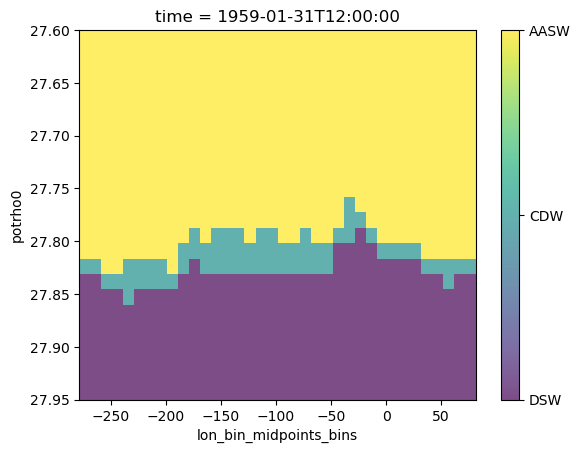

In [122]:
#example of water mass distribution in a specific time
timeind=30
(CDW_age_mask.isel(time=timeind)*2).plot(y='potrho0',vmin=1,vmax=3,add_colorbar=False,alpha=0.7)
DSW_age_mask.isel(time=timeind).plot(y='potrho0',vmin=1,vmax=3,add_colorbar=False,alpha=0.7)
AASW_plot = (AASW_age_mask.isel(time=timeind)*3).plot(y='potrho0',vmin=1,vmax=3,add_colorbar=False,alpha=0.7)
plt.ylim(27.95,27.6);
cbar = plt.colorbar(AASW_plot)
cbar.ax.set_yticks(ticks=[1,2,3],labels=['DSW','CDW','AASW'])

it doesnt seem so.... clean up the mask files to save it

In [129]:
AASW_age_mask_10degbins = AASW_age_mask.rename({'lon_bin_midpoints_bins':'lon_bins'})
CDW_age_mask_10degbins = CDW_age_mask.rename({'lon_bin_midpoints_bins':'lon_bins'})
DSW_age_mask_10degbins = DSW_age_mask.rename({'lon_bin_midpoints_bins':'lon_bins'})

In [133]:
AASW_age_mask_10degbins = AASW_age_mask_10degbins.groupby('time.dayofyear').mean()
CDW_age_mask_10degbins = CDW_age_mask_10degbins.groupby('time.dayofyear').mean()
DSW_age_mask_10degbins = DSW_age_mask_10degbins.groupby('time.dayofyear').mean()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


In [137]:
AASW_age_mask_10degbins.name='AASW_mask'
AASW_age_mask_10degbins['lon_bins'] = lon_bin_mid
AASW_age_mask_10degbins.to_netcdf('/g/data/v45/wf4500/ASC_project_files/AASW_age_Climatology_mask.nc')

CDW_age_mask_10degbins.name='CDW_mask'
CDW_age_mask_10degbins['lon_bins'] = lon_bin_mid
CDW_age_mask_10degbins.to_netcdf('/g/data/v45/wf4500/ASC_project_files/CDW_age_Climatology_mask.nc')

DSW_age_mask_10degbins.name='DSW_mask'
DSW_age_mask_10degbins['lon_bins'] = lon_bin_mid
DSW_age_mask_10degbins.to_netcdf('/g/data/v45/wf4500/ASC_project_files/DSW_age_Climatology_mask.nc')